In [1]:
# Import relevant modules
import os, sys

import numpy as np
import healpy as hp
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import quad
from units import *
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# # Downloads if running for the first time

# # Download Fermi data
# os.system("wget https://dspace.mit.edu/bitstream/handle/1721.1/105492/fermi_data.tar.gz?sequence=5");
# os.system("tar -xvf fermi_data.tar.gz?sequence=5");
# os.system("rm -r fermi_data.tar.gz*");
# os.system("mv fermi_data ../data/");

# # Download spectra
# os.system("wget http://www.marcocirelli.net/PPPC4DMID/AtProduction_gammas.dat.zip");
# os.system("unzip AtProduction_gammas.dat.zip");
# os.system("mv AtProduction_gammas.dat ../data/");
# os.system("rm -r AtProduction_gammas.dat.zip");

In [3]:
# Load relevant maps
fermidata_counts = np.load("../data/fermi_data/fermidata_counts.npy")
fermidata_exposure = np.load("../data/fermi_data/fermidata_exposure.npy")
j_factor_map = np.load("../Bkg-Maps/JfactorSmoothed/SGH_Jfactor_map_NFW_gamma_1.2_smoothed.npy")[10]/(GeV**2*Centimeter**-5) # From lchang

In [4]:
# Set DM parameters and and energy range
m_DM = 40 # Must exist in PPPC4DMID table
channel = 'b'
ebin_ary = [2.,20.]

In [5]:
# Load PP factor from PPPC4DMID
dNdLogx_df=pd.read_csv('../data/AtProduction_gammas.dat', delim_whitespace=True)

dNdLogx_ann_df = dNdLogx_df.query('mDM == ' + (str(np.int(float(m_DM)))))[['Log[10,x]',channel]]
Egamma = np.array(m_DM*(10**dNdLogx_ann_df['Log[10,x]']))
dNdEgamma = np.array(dNdLogx_ann_df[channel]/(Egamma*np.log(10)))
dNdE_interp = interp1d(Egamma, dNdEgamma)

In [6]:
# Get PP in specified bins

PP_noxsec_ary = np.zeros(len(ebin_ary) - 1)

for i in range(len(PP_noxsec_ary)):
    # First integrate to get PP factor - want counts, not counts/GeV
    if ebin_ary[i] < m_DM:
        if ebin_ary[i+1] < m_DM:
            # Whole bin is inside
            PP_noxsec_ary[i] = 1.0/(8*np.pi*m_DM**2)*quad(lambda x: dNdE_interp(x), ebin_ary[i], ebin_ary[i+1], limit=500)[0]
        else:
            # Bin only partially contained
            PP_noxsec_ary[i] = 1.0/(8*np.pi*m_DM**2)*quad(lambda x: dNdE_interp(x), ebin_ary[i], m_DM, limit=500)[0]

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [7]:
# DM cross-sections to consider and number of MCs
xsecs_ary = [0] + list(np.logspace(-27,-24.5,10))
n_MC = 20

In [8]:
# Get expected counts and Poisson fluctuate
DM_counts_temp_ary = [[PP_noxsec*j_factor_map*fermidata_exposure*xsec for PP_noxsec in PP_noxsec_ary] for xsec in xsecs_ary];
DM_counts_ary = [np.random.poisson(DM_counts_temp_ary) for _ in tqdm_notebook(range(n_MC))]

In [9]:
# Indices are i_mc, i_xsec, i_ebin, i_pix 
np.shape(DM_counts_ary)

(20, 11, 1, 196608)

In [10]:
# Add DM maps to Fermi data to get injected signal MCs
fermidata_counts_DM_MC = (fermidata_counts + DM_counts_ary).astype(np.int32)

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


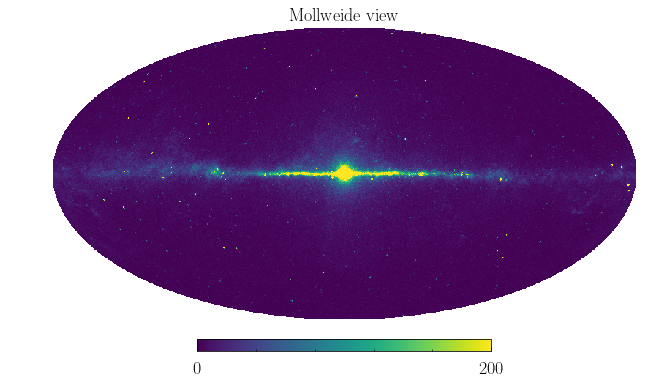

In [11]:
# Look at a particularly bright xsec
hp.mollview(fermidata_counts_DM_MC[0][10][0], max = 200)

In [12]:
# Save injected signal on data sims
np.save("../data/MC_inj_data.npy", fermidata_counts_DM_MC)

In [42]:
# Also save a baseline map to use as template in scans
baseline_gce_map = PP_noxsec_ary*j_factor_map*fermidata_exposure*2e-26
np.save("../data/SGH_Jfactor_map_NFW_gamma_1.2_baseline.npy", baseline_gce_map)